<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/Adrian/fastai_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:

def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [5]:
bs = 32

In [6]:
path = Path('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train')

In [9]:
path_img = path/'.'

In [10]:
fnames = get_image_files(path_img)

len(fnames)
fnames[:5]

[PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.10.jpg'),
 PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.100.jpg'),
 PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.0.jpg'),
 PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.1.jpg'),
 PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.101.jpg')]

In [11]:
np.random.seed(2)
pat = r'([^/]+)\.\d+.jpg$'

In [12]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

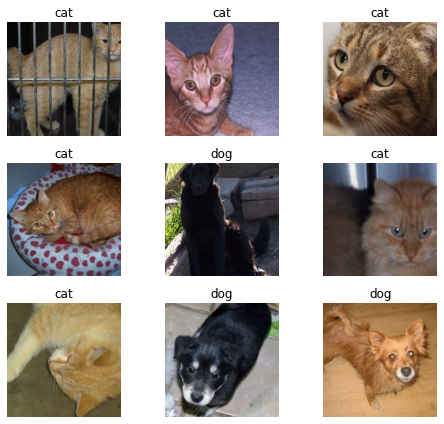

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes)

['cat', 'dog']


2

resnet34

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.676768,0.046498,0.030000,00:10
1,0.365082,0.036747,0.020000,00:07
2,0.233716,0.051553,0.010000,00:07
3,0.184741,0.058838,0.010000,00:07
4,0.137414,0.072094,0.020000,00:07
5,0.110183,0.058595,0.030000,00:07
6,0.097625,0.057069,0.030000,00:07
7,0.081003,0.051830,0.030000,00:08


In [18]:
learn.save('stage-1')

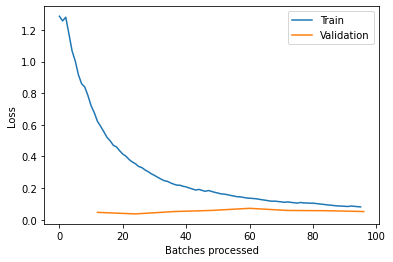

In [19]:
learn.recorder.plot_losses()

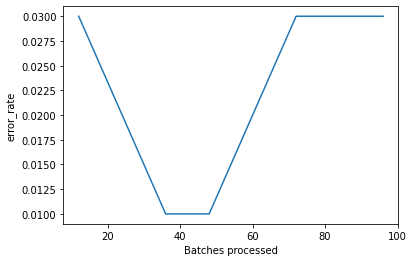

In [20]:
learn.recorder.plot_metrics()

Ergebnisse

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

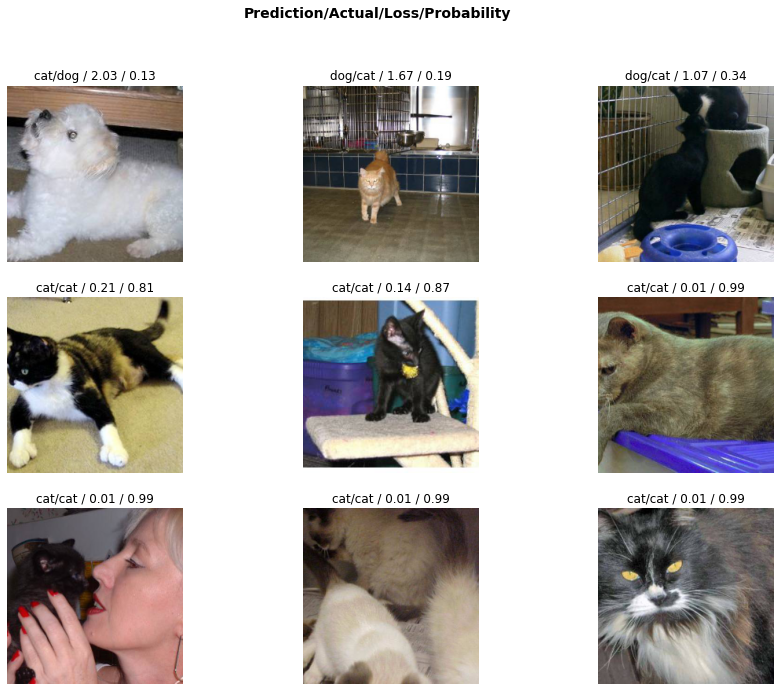

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [23]:
doc(interp.plot_top_losses)

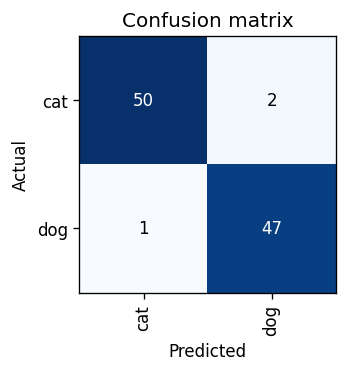

In [24]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=120)

In [25]:
interp.most_confused(min_val=2)

[('cat', 'dog', 2)]

Unfreezing, fine-tuning and learning rates

In [26]:
learn.load('stage-1');

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


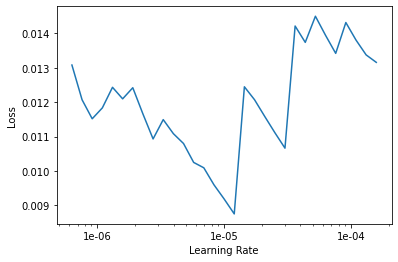

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8, max_lr=slice(10e-6,10e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.050802,0.049587,0.030000,00:08
1,0.044428,0.131443,0.030000,00:08
2,0.042607,0.122988,0.040000,00:08
3,0.056939,0.101898,0.030000,00:08
4,0.046271,0.119937,0.030000,00:08
5,0.049043,0.127818,0.030000,00:08
6,0.039400,0.088856,0.030000,00:08
7,0.043041,0.075352,0.030000,00:08


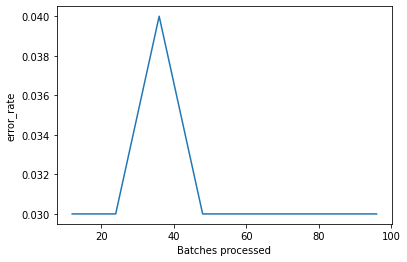

In [30]:
learn.recorder.plot_metrics()

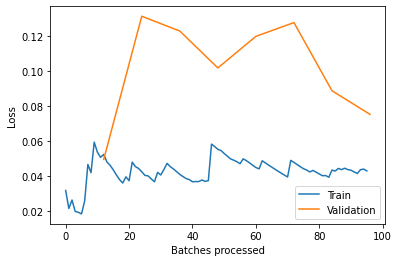

In [31]:
learn.recorder.plot_losses()

In [32]:
interp_unfreeze = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp_unfreeze.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

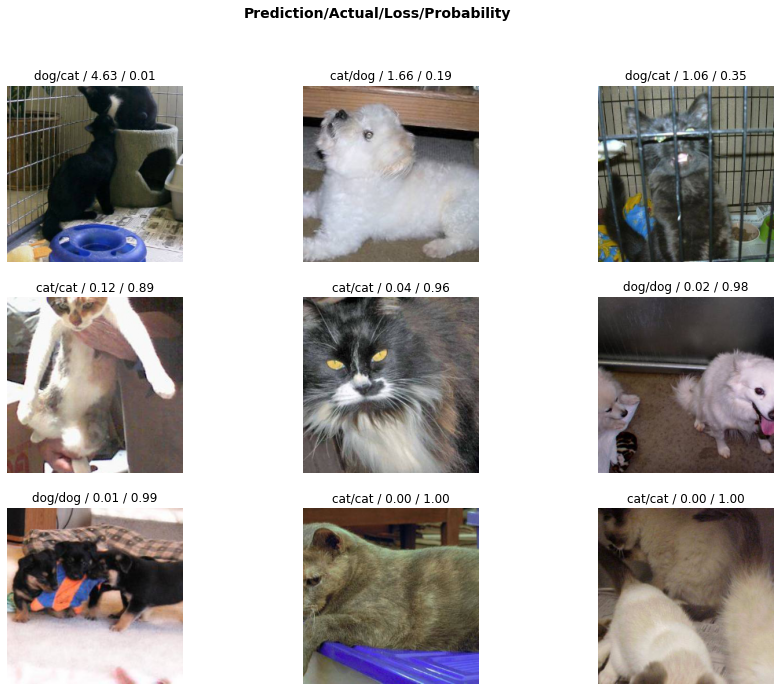

In [33]:
interp_unfreeze.plot_top_losses(9, figsize=(15,11))

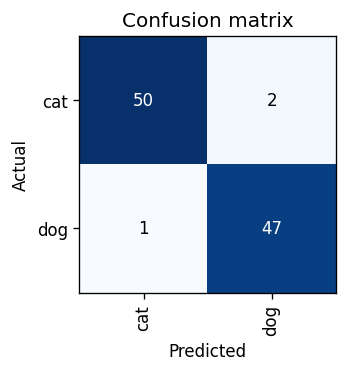

In [34]:
interp_unfreeze.plot_confusion_matrix(figsize=(3,3), dpi=120)

In [35]:
interp_unfreeze.most_confused(min_val=2)

[('cat', 'dog', 2)]

Ab hier Resnet50

In [36]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [37]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


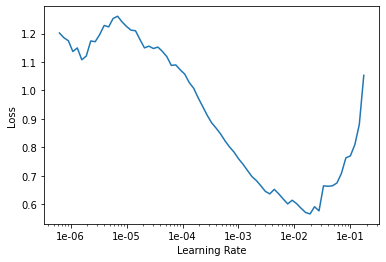

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.307629,0.035762,0.010000,00:18
1,0.229420,0.058258,0.020000,00:14
2,0.202401,0.015899,0.010000,00:14
3,0.169600,0.128479,0.020000,00:14
4,0.138517,0.059597,0.020000,00:14
5,0.148833,0.064566,0.010000,00:14
6,0.104670,0.070307,0.010000,00:14
7,0.075138,0.061003,0.010000,00:14


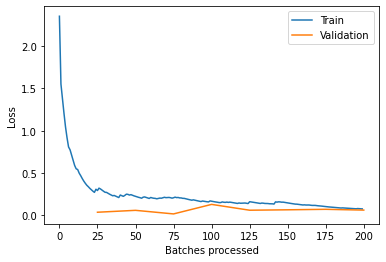

In [40]:
learn.recorder.plot_losses()

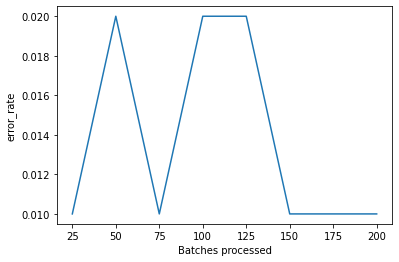

In [41]:
learn.recorder.plot_metrics()

In [42]:
interp_resnet = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp_resnet.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

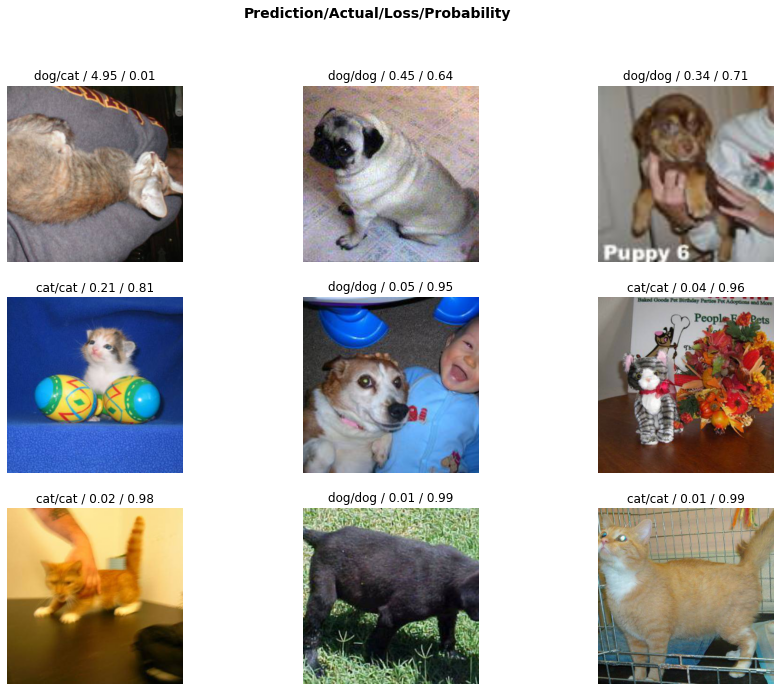

In [43]:
interp_resnet.plot_top_losses(9, figsize=(15,11))

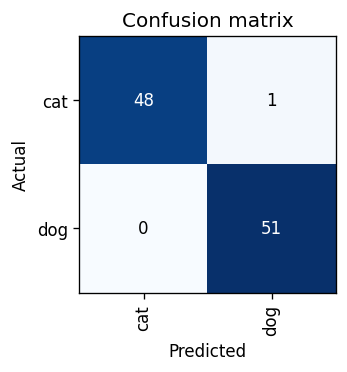

In [44]:
interp_resnet.plot_confusion_matrix(figsize=(3,3), dpi=120)

In [45]:
learn.save('stage-1-50')

Unfreeze:

In [46]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(10e-6,10e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.063555,0.033976,0.010000,00:21
1,0.110623,0.168736,0.070000,00:18
2,0.154952,0.075479,0.040000,00:18
3,0.143741,0.132682,0.030000,00:18
4,0.125424,0.058332,0.030000,00:18
5,0.084699,0.049924,0.030000,00:18
6,0.058760,0.035624,0.030000,00:18
7,0.056860,0.029537,0.020000,00:18


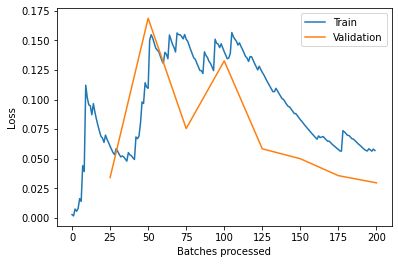

In [47]:
learn.recorder.plot_losses()

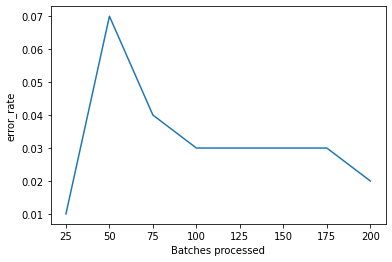

In [48]:
learn.recorder.plot_metrics()

In [49]:
interp_resnet = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp_resnet.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

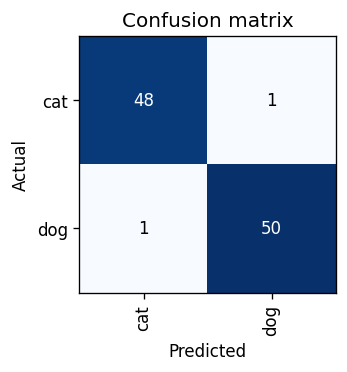

In [50]:
interp_resnet.plot_confusion_matrix(figsize=(3,3), dpi=120)